# Демо-скрипт для выравнивания параллельных текстов на армянском и русском языках

lingtrain-aligner==1.0.2

## Сетап

В качестве инпута подаются два txt-файла на армянском и русском. В скрипте предполагается, что эти файлы лежат на уровне скрипта. Если они лежат в другом месте, нужно прописать путь до файла в переменные `am_input` и `ru_input`. Название для файла, получаемого на выходе (html-документ с раскрашенными предложениями и выровненный csv) нужно задать в переменной `project_name`.

В идеале хорошо бы разметить файлы на предмет метаинформации: `Лю Ци Синь%%%%%author.`, `Задача трёх тел%%%%%title.` и т.д., иначе заголовок сливается с основным текстом, т.к. между ними нет разделяющего знака препинания. Теги для такой разметки можно посмотреть в "полезных ссылках ниже".

Результаты обработки сохраняются в папку `result` по умолчанию, но можно поменять название папки установив его в переменной `output_dir`.

## Полезные ссылки
- Статья про инструмент и метки для указания метинформации https://habr.com/ru/articles/704958/
- github проекта https://github.com/averkij/lingtrain-aligner/tree/main
- основывалась на скрипте https://colab.research.google.com/drive/1lgmgCJuFAqjEI2zqn9RWPcQuO6rxC80f?usp=sharing#scrollTo=bZ0ZlbNqqjV6

In [1]:
#@title Установим зависимости

!pip install -q -U lingtrain-aligner==1.0.2
!pip install -q razdel dateparser sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 22.2 MB/s eta 0:00:00


In [2]:
#@title Импортируем библиотеки
import os
import zipfile
import shutil
import datetime

from lingtrain_aligner import preprocessor, splitter, aligner, resolver, reader, helper, vis_helper
import pandas as pd
import itertools

In [3]:
# зададим общие переменные
output_dir = 'result'
if not os.path.exists(output_dir):
  os.mkdir(output_dir)

models = ["sentence_transformer_multilingual", "sentence_transformer_multilingual_labse"]
model_name = models[0]

In [30]:
#@title Класс для обработки (нужно запустить)

# количество итераций для разрешения конфликтов
MAX_ITERATIONS = 3 # @param {"type":"integer"}

class pair2Align:
    def __init__(self, text_from_name, text_to_name, project_name, lang_from, lang_to, model):

      self.success = False

      self.text_from_name = text_from_name
      self.text_to_name = text_to_name
      assert project_name, 'Нужно передать название текста!'
      self.project_name = project_name
      self.db_path = project_name + '.db'

      self.lang_from = lang_from
      self.lang_to = lang_to

      # конфигурации для формирования html-документа
      self.lang_ordered = ["from", "to"]

      # запускаем пайп
      self.load_from()
      self.load_to()

      # проверяем на условную параллельность
      # chrf = nonparallel_bool(''.join(self.text_from[:100])[:3000] if lang_to=='ru' else ''.join(self.text_to[:100])[:3000], ''.join(self.text_to[:100])[:3000] if lang_to=='ru' else ''.join(self.text_from[:100])[:3000])
      # if chrf < 0.7:
      #   print(f'НЕПАРАЛЛЕЛЬНЫЕ ТЕКСТЫ {self.project_name}! chrF =', chrf)
      #   return

      self.split_by_sent()
      self.conflicts = self.align()
      self.resolve_conflicts()
      self.get_aligned()

      self.success = True

    def load_from(self):
    # Оригинальный текст
      with open(self.text_from_name, "r", encoding="utf8") as input1:
        self.text_from = input1.readlines()
      print(f'Загружен оригинальный текст из {self.text_from_name}')

    def load_to(self):
    # Текст перевода
      with open(self.text_to_name, "r", encoding="utf8") as input2:
        self.text_to = input2.readlines()
      print(f'Загружен текст перевода из {self.text_to_name}')

    def split_by_sent(self):
      # Добавим метки абзацев, они пригодятся позже
      text_from_prepared = preprocessor.mark_paragraphs(self.text_from)
      text_to_prepared = preprocessor.mark_paragraphs(self.text_to)

      self.splitted_from = splitter.split_by_sentences_wrapper(text_from_prepared, lang_from)
      self.splitted_to = splitter.split_by_sentences_wrapper(text_to_prepared, lang_to)

      print(f'Предложений в оригинальном тексте ({lang_from}):', len(self.splitted_from))
      print(f'Предложений в тексте перевода ({lang_to})', len(self.splitted_to))

    def align(self):
      """
      for c in conflicts_to_solve:
        resolver.show_conflict(db_path, c)
      """

      if os.path.isfile(self.db_path):
        os.unlink(self.db_path)

      aligner.fill_db(self.db_path, lang_from, lang_to, self.splitted_from, self.splitted_to)

      # IMPORTANT: only part (also just below when called)
      # batch_ids = [_ for _ in range(0,10)]

      aligner.align_db(self.db_path, \
                      model_name, \
                      batch_size=100, \
                      window=40, \
                      # batch_ids=batch_ids, \
                      save_pic=False,
                      embed_batch_size=10, \
                      normalize_embeddings=True, \
                      show_progress_bar=True
                      )
      vis_helper.visualize_alignment_by_db(self.db_path, output_path='viz.png', lang_name_from=self.lang_from, lang_name_to=self.lang_to, batch_size=400, size=(800,800), plt_show=True)

      return resolver.get_all_conflicts(self.db_path, min_chain_length=2, max_conflicts_len=MAX_ITERATIONS, batch_id=-1) # conflicts_to_solve, rest -> resolver.get_statistics(conflicts_to_solve), resolver.get_statistics(rest)


    def resolve_conflicts(self, steps=5):
      batch_id = -1 #выровнять все доступные батчи

      for i in range(steps):
          conflicts, rest = resolver.get_all_conflicts(self.db_path, min_chain_length=2+i, max_conflicts_len=MAX_ITERATIONS*(i+1), batch_id=batch_id, handle_start=True, handle_finish=True)
          resolver.resolve_all_conflicts(self.db_path, conflicts, model_name, show_logs=False)
          vis_helper.visualize_alignment_by_db(self.db_path, output_path='viz.png', lang_name_from=self.lang_from, lang_name_to=self.lang_to, batch_size=400, size=(600,600), plt_show=True)

          if len(rest) == 0: break
      print('Конфликты разрешены')

    def save_book(self, output_filename, output_dir=None, custom_styles=[]):
      """
      # можно передать свои правила для оформления книжки
      my_style = [
          '{"background": "#A2E4B8", "color": "black", "border-bottom": "0px solid red"}',
          '{"background": "#FFC1CC", "color": "black"}',
          '{"background": "#9BD3DD", "color": "black"}',
          '{"background": "#FFFCC9", "color": "black"}'
          ]
      save_aligned(custom_styles=my_style)
      """
      output_path = os.path.join(output_dir, output_filename +".html")
      if not os.path.exists(output_dir):
        os.mkdir(output_dir)

      paragraphs, delimeters, metas, sent_counter = reader.get_paragraphs(
          self.db_path, direction="to"
      )

      reader.create_book(
          lang_ordered=self.lang_ordered,
          paragraphs=paragraphs,
          delimeters=delimeters,
          metas=metas,
          sent_counter=sent_counter,
          output_path=output_path,
          template="pastel_fill",
          styles=custom_styles,
      )

    def get_aligned(self):

      paragraphs_from, paragraphs_to, meta, _ = reader.get_paragraphs(self.db_path)

      sents_from = list(itertools.chain.from_iterable(paragraphs_from['from']))
      sents_to = list(itertools.chain.from_iterable(paragraphs_from['to']))

      self.aligned_df = pd.DataFrame(data=[sents_from, sents_to], index=[self.lang_from, self.lang_to]).T

    @staticmethod
    def save_table(df, output_dir, out_filename):
      """
      pair2Align.save_table(proj.aligned_df, output_dir, out_filename=project_name)
      """
      # сохраняем в excel а не в csv на случай, если нужно будет подправить что-то руками
      df.to_excel(f'{output_dir}/{out_filename}.xlsx', index=False)


In [33]:
def lingtrain_align(path_from, path_to, project_name, lang_from, lang_to, model_name):
  """
  Выравнивание с помощью lingtrain-aligner
  """

  proj = pair2Align(text_from_name=path_from, text_to_name=path_to, project_name=project_name, lang_from=lang_from, lang_to=lang_to, model=model_name)
  # print(proj.success)

  # сохраняем таблицу с выровненными предложениями в папку
  if proj.success:
    pair2Align.save_table(proj.aligned_df, output_dir, out_filename=project_name)
  else:
    exceptions.append(proj.project_name)

def simple_align(path_from, path_to, project_name):
  """
  Простое выравнивание посредством слепления всего файла в одну строку.
  Текст на армянском помещается в первый столбец, на русском -- во второй.
  """

  with open(path_from, 'r', encoding='utf8') as am_f:
    am_text = ' '.join(am_f.readlines()).strip()

  with open(path_to, 'r', encoding='utf8') as ru_f:
    ru_text = ' '.join(ru_f.readlines()).strip()

  df = pd.DataFrame(data=[am_text, ru_text], index=['hy', 'ru']).T
  df = df.replace('\s+', ' ', regex=True)

  df.to_excel(os.path.join(output_dir, project_name+'.xlsx'), index=False)
  print('ONELINER')


<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3334104997.py:28: SyntaxWarning: invalid escape sequence '\s'
  df = df.replace('\s+', ' ', regex=True)


## Перед выравниванием проверяем пары текстов на параллельность и исключаем непараллельные тексты

Непосредственно параллельность проверить не получится, поэтому будем опираться нан метрику chrF.

Процедура:
1) переводим текст на армянском на русский
2) считаем chrF
3) если chrF меньше 80, то добавляем пару текстов в исключения  

In [6]:
# !pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
# from deep_translator import GoogleTranslator
# from nltk.translate.chrf_score import sentence_chrf

# def nonparallel_bool(armenian_true, russian_true):
#   translator = GoogleTranslator(source='armenian', target='russian')
#   russian_trans = translator.translate(armenian_true)

#   chrf_score = sentence_chrf(russian_true, russian_trans)

#   return chrf_score

## Запускаем обработку пар текстов в цикле

In [28]:
# если есть файлы, которые нужно исключить вручную, то перечисляем их в переменной exceptions.
# Указываем только основную часть названия -- то есть без расширения и кода языка.
# Например, есть файлы 1128107_am.txt и 1128107_ru.txt, которые мы хотим исключить, тогда в список добавляем значение 1128107
exceptions = ['1128107', 'kapitanskaya_dochka']
exceptions_file = '_exceptions.txt'  # @param {"type":"string"}

if os.path.exists(exceptions_file):
  with open(exceptions_file, 'r+') as file:
      # Read all lines and create a list
      exceptions.extend(file.read().splitlines())
  len('Количество исключений:', exceptions)
else:
  print('The specified file does not exist!')

The specified file does not exist!


In [ ]:
# OPTIONAL: вытаскиваем из архива уже выровненные тексты в папку
# (если например нужно обработать 200 пар в два дня, можно сохранить прогресс в архив и продолжить обрабатывать остаток в другой день)
! unzip result_20260109_195034.zip -d result

In [ ]:
# архив с парными текстами без .zip
input_zip = 'liter' # @param {"type":"string"}

In [ ]:
# вытаскиваем из архива пары текстов в формате .txt
! unzip {input_zip}.zip

In [12]:
from google.colab import files

def backup(exceptions_file, ts):
  with open(exceptions_file, 'w') as file:
      # Join the list items with a newline character and write to the file
      file.write('\n'.join(exceptions) + '\n')

  zip_filename = output_dir + '_' + ts
  shutil.make_archive(zip_filename, 'zip', output_dir)

14:52:12
arzrum
Загружен оригинальный текст из liter/arzrum_ru.txt
Загружен текст перевода из liter/arzrum_am.txt
Предложений в оригинальном тексте (ru): 1014
Предложений в тексте перевода (hy) 1033
Aligning without segments.
tasks amount: 11
batch: 0 (0)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

batch: 1 (1)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 2 (2)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 3 (3)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 4 (4)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 5 (5)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 6 (6)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 7 (7)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 8 (8)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

batch: 9 (9)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

batch: 10 (10)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

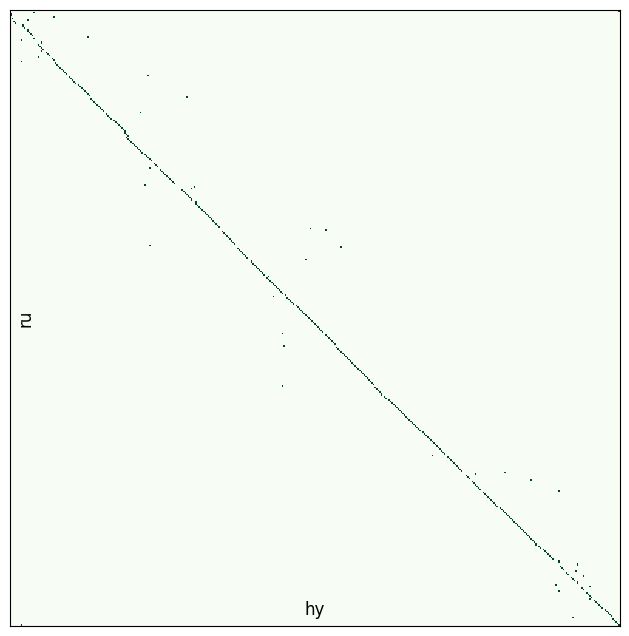

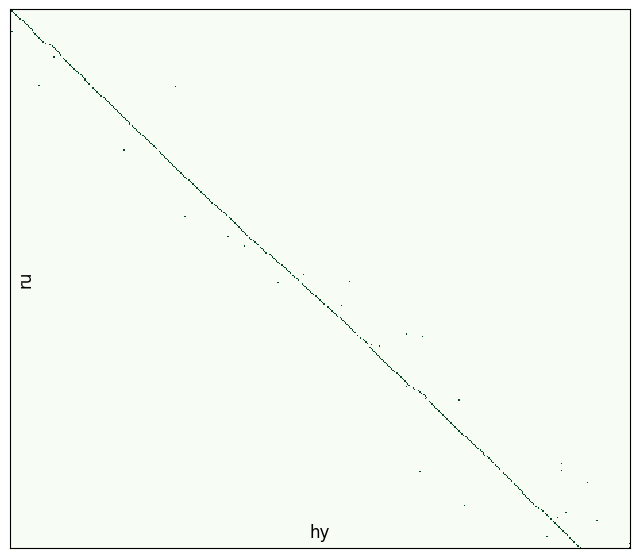

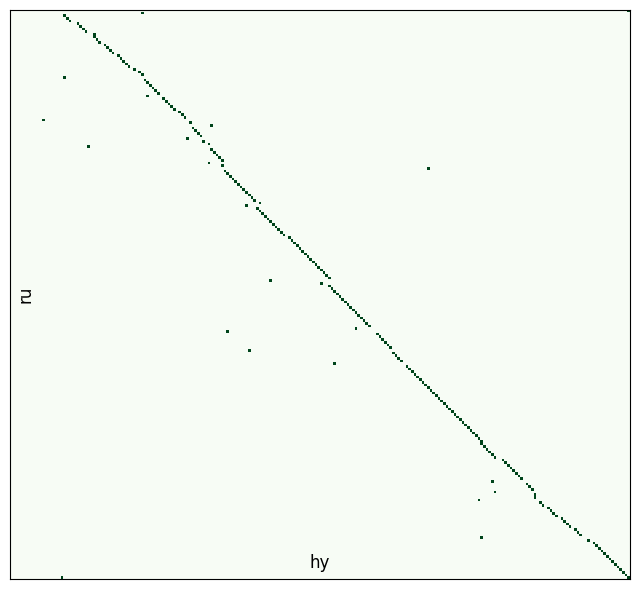

conflicts to solve: 79
total conflicts: 118
conflicts to solve: 79
total conflicts: 119


100%|██████████| 79/79 [00:42<00:00,  1.84it/s]


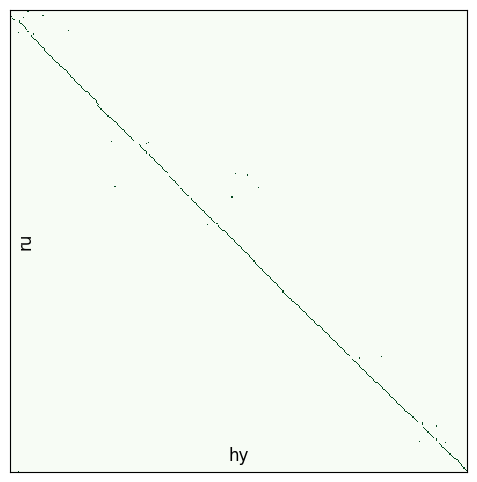

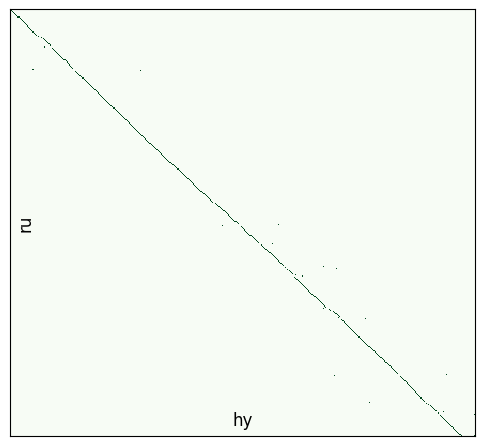

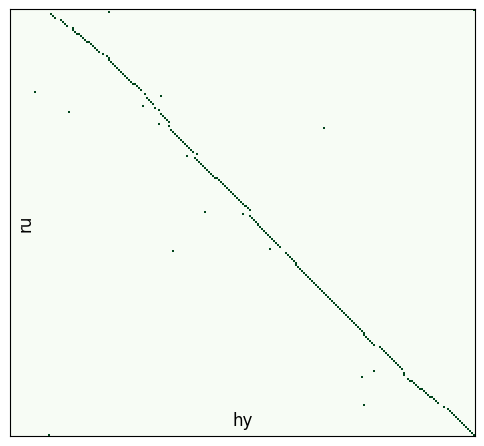

conflicts to solve: 31
total conflicts: 38


100%|██████████| 31/31 [00:34<00:00,  1.10s/it]


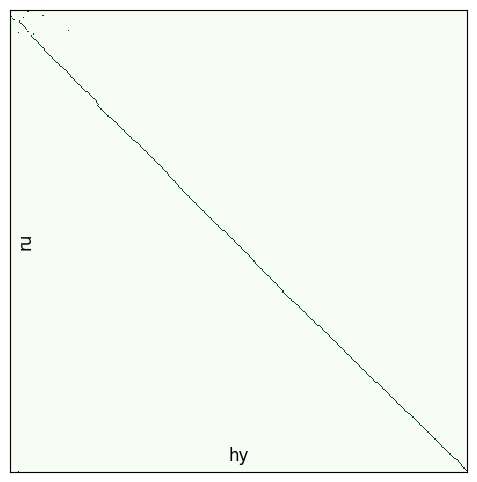

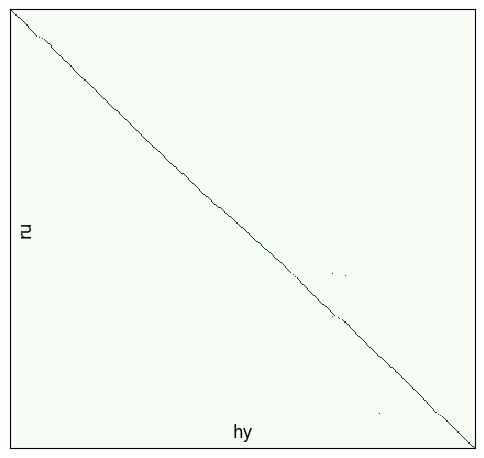

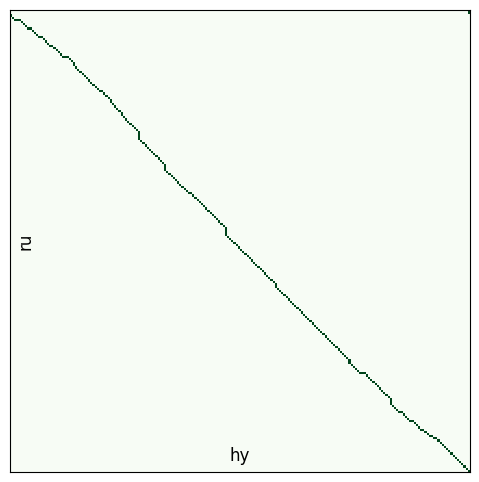

conflicts to solve: 5
total conflicts: 7


100%|██████████| 5/5 [00:24<00:00,  4.98s/it]


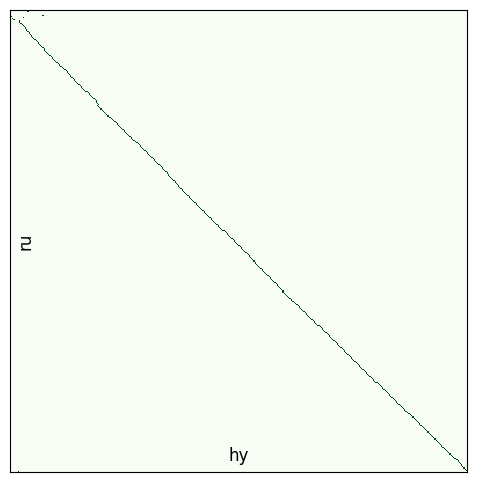

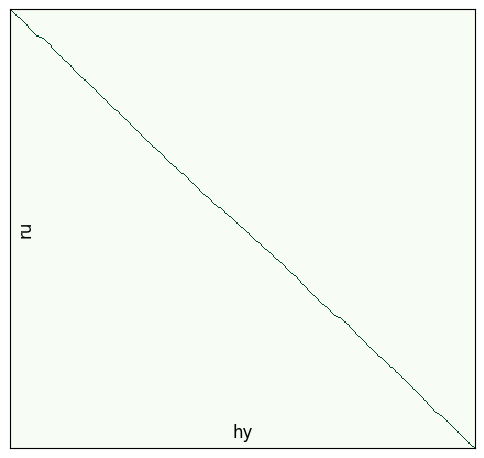

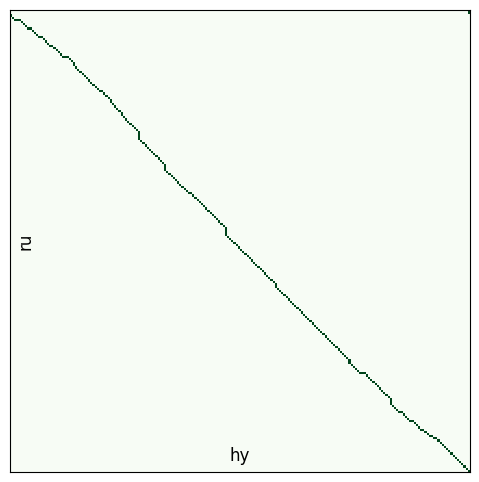

conflicts to solve: 1
total conflicts: 2


100%|██████████| 1/1 [00:10<00:00, 10.31s/it]


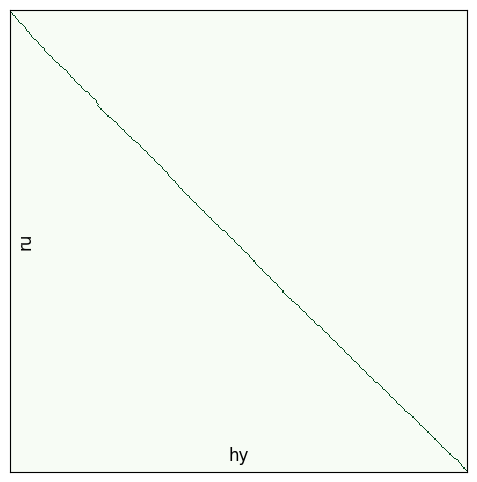

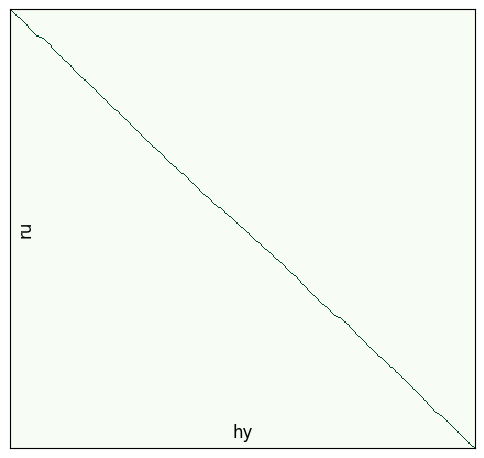

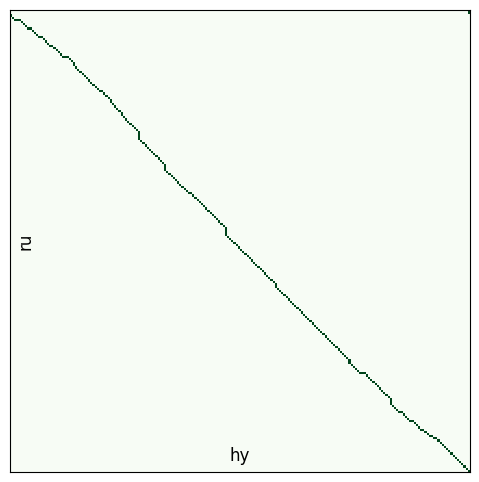

conflicts to solve: 0
total conflicts: 1


0it [00:00, ?it/s]


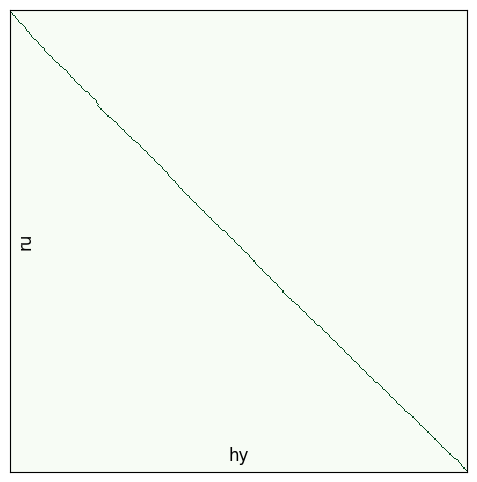

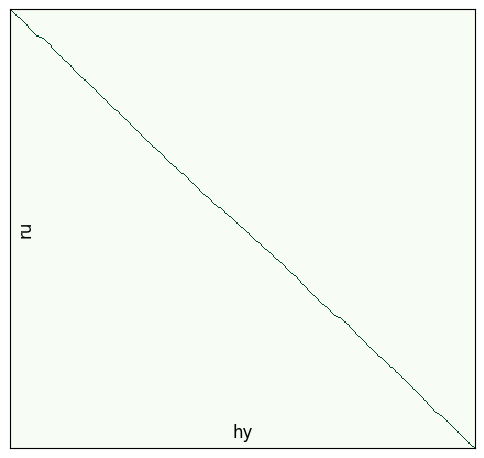

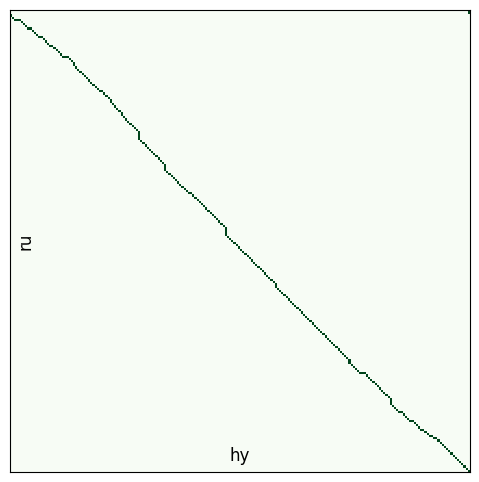

Конфликты разрешены
1 done
--------------------------------------------------


In [37]:
from types import NoneType
import os
import re

# None, если файлы лежат в корневой папке
input_dir = 'liter' # @param {"type":"string"}
output_dir = 'result' # @param {"type":"string"}
done = os.listdir(output_dir)
done = list(map(lambda f: f.replace('.xlsx', ''), done))

fnames = list(filter(lambda f: f.endswith('.txt') and re.sub('(_am|am_|_ru|ru_)', '', f).replace('.txt', '') not in done+exceptions, os.listdir(input_dir)))
fnames = set(map(lambda f: re.sub('(_am|am_|_ru|ru_)', '', f).replace('.txt', ''), fnames))

# язык оригинала
lang_from = "ru" # @param ["hy","ru"]
# язык перевода
lang_to = "hy" # @param ["hy","ru"]

cntr = 0

for project_name in fnames:

  # if cntr % 500 == 0:
  #   backup(exceptions_file=exceptions_file, ts=datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))

  print(datetime.datetime.now().strftime('%H:%M:%S'))
  print(project_name)

  cur_timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
  db_path = f"{cur_timestamp}.db"

  # название файла на русском (до .txt)
  ru_input = f"{project_name}_ru"
  # название файла на армянском (до .txt)
  am_input = f"{project_name}_am"
  # print(ru_input, am_input)

  ru_input = ru_input+'.txt'
  am_input = am_input+'.txt'

  # print(ru_input, am_input)

  try:
    lingtrain_align(
        path_from=os.path.join(input_dir, am_input) if lang_from == "hy" else os.path.join(input_dir, ru_input),
        path_to=os.path.join(input_dir, am_input) if lang_to == "hy" else os.path.join(input_dir, ru_input),
        project_name=project_name,
        lang_from=lang_from,
        lang_to=lang_to,
        model_name=model_name
    )
  except TypeError:
    # такая ошибка выбрасывается, когда файл состоит из одной строки текста
    simple_align(
        path_from=os.path.join(input_dir, am_input) if lang_from == "hy" else os.path.join(input_dir, ru_input),
        path_to=os.path.join(input_dir, am_input) if lang_to == "hy" else os.path.join(input_dir, ru_input),
        project_name=project_name,
    )

  cntr += 1

  print(cntr, 'done')
  print('-'*50)

# backup(exceptions_file=exceptions_file, ts=datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
# files.download(zip_filename+'.zip')
# files.download(exceptions_file)


In [39]:
(len(os.listdir(input_dir))-1)/2 , len(set(exceptions))+len(done)

(1.0, 3)

In [ ]:
!rm *.db

In [ ]:
zip_filename = output_dir
shutil.make_archive(zip_filename, 'zip', output_dir)

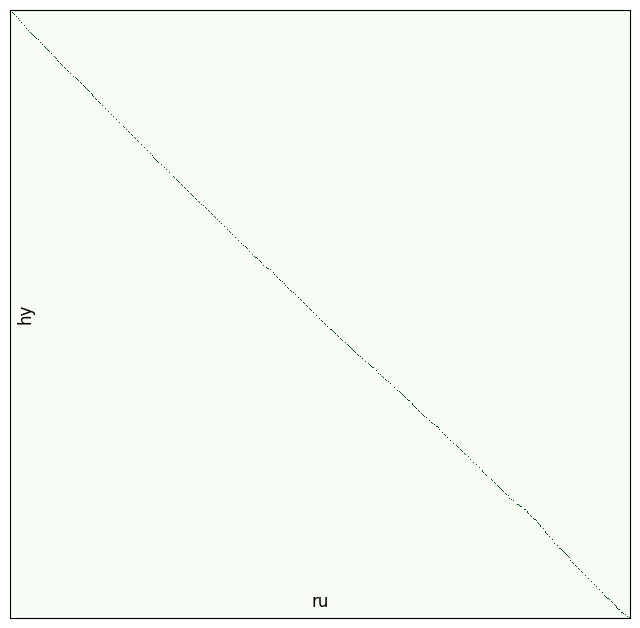

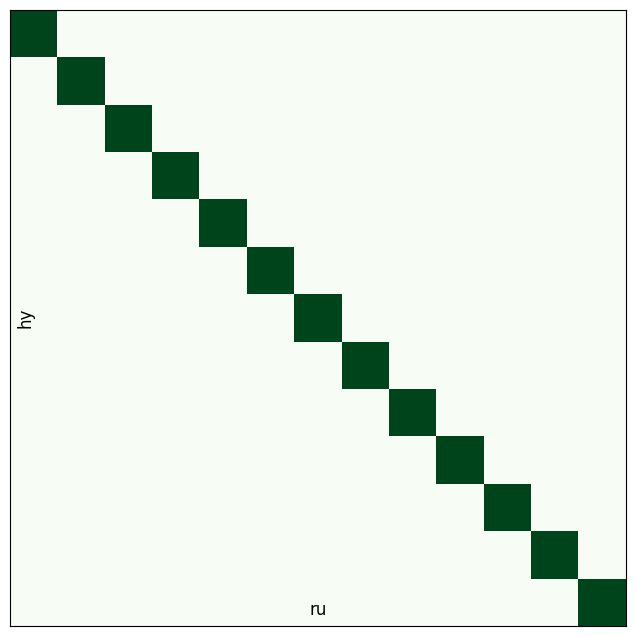

In [42]:
vis_helper.visualize_alignment_by_db(db_path='arzrum.db', output_path='viz.png', lang_name_from='hy', lang_name_to='ru', batch_size=1000, size=(800,800), plt_show=True)